In [1]:
import os
import time

import matplotlib.pyplot as plt
import rasterio
import wandb
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

from messis.messis import Messis
from messis.dataloader import GeospatialDataModule

## get characteristics on our two training data source tifs

In [2]:
def load_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        print(img.shape)
        print(img.dtype)
        print(img.max())
        print(img.min())
        print(img.mean())

load_image('./data/chips/._chip_000_008_fold_0_merged.tif')
print('---')
load_image('./data/chips/._chip_000_008_fold_0_mask.tif')

(18, 256, 256)
uint16
7256
1
1445.3756866455078
---
(3, 256, 256)
uint8
33
0
1.356201171875


## benchmark rasterio loading speed

In [12]:
# performance measurement: read all images in the training set and mesure time per file

def load_all_images():
    start = time.time()
    times = []
    for root, dirs, files in os.walk('./data/chips'):
        for file in files[:100]:
            start = time.time()
            if file.endswith('.tif'):
                with rasterio.open(os.path.join(root, file)) as src:
                    img = src.read()
            times.append(time.time() - start)
    print('mean time per file:', sum(times) / len(times))

load_all_images()

mean time per file: 0.00379990816116333


## sanity check our dataset

Plotting the masks of all 3 tiers.

(3, 256, 256)
uint8
33
0
1.356201171875


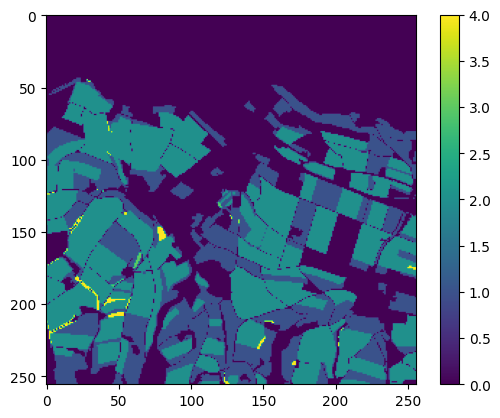

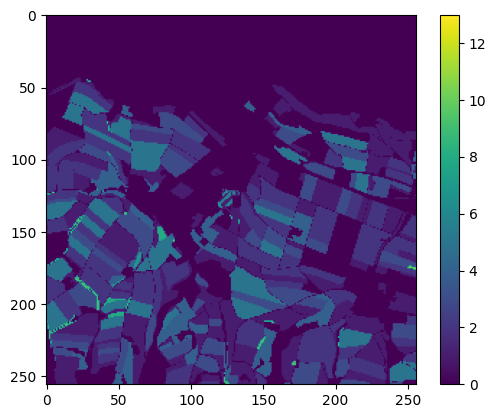

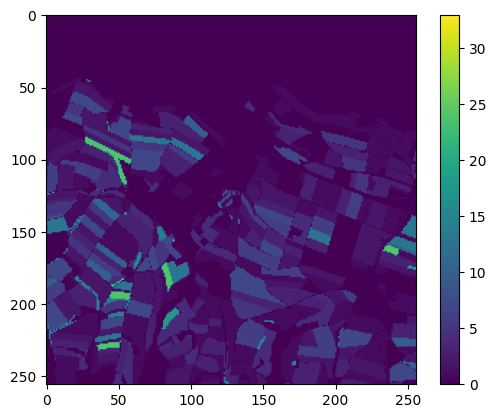

In [14]:
data = rasterio.open('./data/chips/._chip_000_008_fold_0_mask.tif').read()
type(data)

load_image('./data/chips/._chip_000_008_fold_0_mask.tif')

# plot all channels from data

def plot_channels(data):
    for i in range(data.shape[0]):
        plt.imshow(data[i])
        plt.colorbar()
        plt.show()

plot_channels(data)

Plotting the RGB bamds of the first timestep in our merged geotiff.

(18, 256, 256)
uint16
6789
57
1437.7442372639973


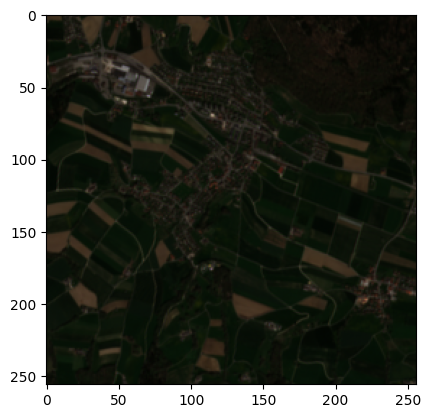

In [24]:
load_image('./data/chips/._chip_000_008_fold_0_merged.tif')

# get channel 0, 1 and 2, plot as RGB image
merged = rasterio.open('./data/chips/._chip_000_008_fold_0_merged.tif').read()

# normalize values to be between 0 and 1
data = (merged - merged.min()) / (merged.max() - merged.min())

def plot_rgb(data):
    plt.imshow(data[[0, 1, 2]].transpose(1, 2, 0))
    plt.show()

plot_rgb(data) 

## dataloader test

In [1]:

data = GeospatialDataModule('./data/', 1, debug=True)
data.setup()

train = data.train_dataloader()

Loading mean/std stats from ../data/data/chips_fold_stats.yaml
Stats with selected test fold 1: {'mean': [509.1767272949219, 610.8715209960938, 362.144775390625, 3127.99267578125, 1819.3131103515625, 1075.4163818359375], 'n_bands': 6, 'n_chips': 274, 'n_timesteps': 3, 'std': [432.1478576660156, 337.9712219238281, 295.7602233886719, 1191.172119140625, 614.9256591796875, 569.3043823242188]} over 3 timesteps.
Loading mean/std stats from ../data/data/chips_fold_stats.yaml
Stats with selected test fold 1: {'mean': [509.1767272949219, 610.8715209960938, 362.144775390625, 3127.99267578125, 1819.3131103515625, 1075.4163818359375], 'n_bands': 6, 'n_chips': 274, 'n_timesteps': 3, 'std': [432.1478576660156, 337.9712219238281, 295.7602233886719, 1191.172119140625, 614.9256591796875, 569.3043823242188]} over 3 timesteps.
Loading mean/std stats from ../data/data/chips_fold_stats.yaml
Stats with selected test fold 1: {'mean': [509.1767272949219, 610.8715209960938, 362.144775390625, 3127.99267578125, 

In [2]:
# get first batch from train
for batch in train:
    first_batch = batch
    break

In [5]:
inputs, targets = first_batch

print("inputs shape:", inputs.shape)
print("targets shape:", targets[0].shape, targets[1].shape, targets[2].shape)

inputs shape: torch.Size([8, 6, 3, 256, 256])
targets shape: torch.Size([8, 256, 256]) torch.Size([8, 256, 256]) torch.Size([8, 256, 256])


In [6]:
t1, t2, t3 = targets

In [7]:
# min and max values for each target
print(t1.min(), t1.max())
print(t2.min(), t2.max())
print(t3.min(), t3.max())

tensor(0, dtype=torch.uint8) tensor(5, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(14, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(46, dtype=torch.uint8)


Targets seem to be loaded correctly.

## test model training

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yvokeller (t_buess). Use `wandb login --relogin` to force relogin


True

Read the number of classes per tier, so we can set that correctly in our model.

In [3]:
# read labels.tif 
labels = rasterio.open('./data/labels_hierarchy.tif').read()
labels.shape

classes_tier1 = labels[0]
classes_tier2 = labels[1]
classes_tier3 = labels[2]

num_classes_tier1 = len(set(classes_tier1.flatten()))
num_classes_tier2 = len(set(classes_tier2.flatten()))
num_classes_tier3 = len(set(classes_tier3.flatten()))
print('Number of Classes in Tier 1:', num_classes_tier1)
print('Number of Classes in Tier 2:', num_classes_tier2)
print('Number of Classes in Tier 3:', num_classes_tier3)

Number of Classes in Tier 1: 6
Number of Classes in Tier 2: 17
Number of Classes in Tier 3: 49


TODO: We have to find a solution for the dimension mismatch between Prithvi pre-trained embeddings and our new img_size.

- pretrained embeddings by Prithvi expect 14 x 14 patches of size 16 x 16 (224 / 16 = 14)
- we now have 16 x 16 patches of size 16 x 16 (256 / 16 = 16)

In [4]:
"""# Create a W&B logger
wandb_logger = WandbLogger(entity='yvokeller', project='messis', log_model='all')

# Make sure to pass your Hyperparameters as a dictionary
hparams = {
    'num_classes_tier1': num_classes_tier1,
    'num_classes_tier2': num_classes_tier2,
    'num_classes_tier3': num_classes_tier3,
    'img_size': 256, # new image size
    'patch_size': 16,
    'num_frames': 3,
    'bands': [0, 1, 2, 3, 4, 5],
    'weight_tier1': 1,
    'weight_tier2': 1,
    'weight_tier3': 1,
    'weight_tier3_refined': 1,
    'debug': True,
    'lr': 1e-3
}

# Instantiate the Lightning module
model = Messis(hparams)

# Setup the data module
data_module = GeospatialDataModule(data_dir='./data/', test_fold=1, batch_size=32, num_workers=4)

# Initialize the Trainer
trainer = Trainer(
    logger=wandb_logger,    # Attach the logger
    max_epochs=1            # Set the number of epochs
)

# Start training
trainer.fit(model, datamodule=data_module)"""

hp and wp:  16 16


RuntimeError: Error(s) in loading state_dict for TemporalViTEncoder:
	size mismatch for pos_embed: copying a param with shape torch.Size([1, 589, 768]) from checkpoint, the shape in current model is torch.Size([1, 769, 768]).

let's try what happens when we crop our images down to 224 x 224

In [4]:
# Create a W&B logger
from messis.messis import LogConfusionMatrix


wandb_logger = WandbLogger(entity='crop-classification', project='messis', log_model='all')

# Make sure to pass your Hyperparameters as a dictionary
hparams = {
    'num_classes_tier1': num_classes_tier1,
    'num_classes_tier2': num_classes_tier2,
    'num_classes_tier3': num_classes_tier3,
    'img_size': 224, # new image size
    'patch_size': 16,
    'num_frames': 3,
    'bands': [0, 1, 2, 3, 4, 5],
    'weight_tier1': 1,
    'weight_tier2': 1,
    'weight_tier3': 1,
    'weight_tier3_refined': 1,
    'debug': False,
    'lr': 1e-3
}

# Instantiate the Lightning module
model = Messis(hparams)

# Setup the data module 
data_module = GeospatialDataModule(data_dir='./data/', test_fold=1, batch_size=4, num_workers=1, crop_to=224)

# Initialize the Trainer
trainer = Trainer(
    callbacks=[LogConfusionMatrix()],
    logger=wandb_logger,    # Attach the logger
    max_epochs=5            # Set the number of epochs
)

# Start training
trainer.fit(model, datamodule=data_module)

Loaded pretrained weights from './prithvi/models/Prithvi_100M.pt' with partial matching.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: yvokeller. Use `wandb login --relogin` to force relogin



  | Name  | Type                   | Params
-------------------------------------------------
0 | model | HierarchicalClassifier | 178 M 
-------------------------------------------------
91.8 M    Trainable params
86.7 M    Non-trainable params
178 M     Total params
713.849   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvokeller/Library/Caches/pypoetry/virtualenvs/messis-E9xOSKpc-py3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/yvokeller/Library/Caches/pypoetry/virtualenvs/messis-E9xOSKpc-py3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
